# Aplicar DecisionTreeRegressor y DecisionTreeClassifier sobre los datos limpios

**Autor:** Juan Manuel Martínez Estrada  
**Fecha:** 2025-06-05  
**Versión:** 1.0  

---

# 1. Configuración del Entorno y Rutas

---

* Importación de Librerías

In [461]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import joblib

* Importación de Librerías Personalizadas

In [462]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.train_sklearn_models as tsm
import src.data as data

* Configuración Global

In [463]:
# Configración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

* Rutas

In [464]:
data_path = os.path.join('..', '..', '01_data_preparation', 'data', 'processed', 'dataset_processed.csv') 

* Cargando el dataset en un DataFrame de pandas

In [465]:
df = data.cargar_datos(data_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   datetime                            3060 non-null   object 
 1   Sector                              3060 non-null   object 
 2   Hydroelectric Power                 3060 non-null   float64
 3   Geothermal Energy                   3060 non-null   float64
 4   Solar Energy                        3060 non-null   float64
 5   Wind Energy                         3060 non-null   float64
 6   Wood Energy                         3060 non-null   float64
 7   Waste Energy                        3060 non-null   float64
 8   Fuel Ethanol, Excluding Denaturant  3060 non-null   float64
 9   Biomass Losses and Co-products      3060 non-null   float64
 10  Biomass Energy                      3060 non-null   float64
 11  Total Renewable Energy              3060 no

---

# 2. REGRESIÓN con `DecisionTreeRegressor`

---

## 2.1. Definición del Problema de Regresión

Para empezar se debe plantear de forma clara el problema que se quiere abordar por medio del algoritmo de `arbol de decisión`, para esto se debe definir la variable objetivo `(target)` y las variables independientes `(features)`, para el correcto entrenamiento del modelo en cuestion. 

En este caso análizando el dataset de `consumo de energías renovables en USA (1973 - 2024)` se identifico una fuente de energía en cuestión como posible candidata a su crecimiento emergente y su importancia en la ultima decada, dicha fuente corresponde `Solar Energy`, por lo que se definirá como variable objetivo, mientras que las variables independientes corresponderán a cada uno de los años y meses del dataset, de tal forma que se pueda entrenar un modelo que prediga el consumo de energía solar en función de los años y meses (patrones temporales).

* Definiendo la varaible objetivo

In [466]:
target_reg = 'Solar Energy'

* Crear caracteristicas

In [467]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Copiamos para no modificar el df original de este notebook
df_features_reg = df.iloc[2160:].copy()

# Características Temporales Básicas (del índice datetime)
df_features_reg['year'] = df_features_reg['datetime'].dt.year
df_features_reg['month'] = df_features_reg['datetime'].dt.month

df_features_reg.tail(30)

,datetime,Sector,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Total Renewable Energy,Renewable Diesel Fuel,Other Biofuels,Conventional Hydroelectric Power,Biodiesel,year,month
3030,2023-07-01,Commercial,0.24,1.67,7.32,0.02,6.88,6.29,2.69,69.98,15.86,241.03,33.81,3.04,70.84,22.40,2023,7
3031,2023-07-01,Electric Power,0.24,4.45,64.04,95.16,16.24,14.10,2.19,70.37,30.34,426.84,32.57,3.10,72.01,22.03,2023,7
3032,2023-07-01,Industrial,0.25,0.36,1.71,0.02,100.83,12.49,1.69,70.76,185.78,502.01,31.33,3.17,71.96,21.66,2023,7
3033,2023-07-01,Residential,0.25,3.36,24.62,0.02,38.25,10.40,48.35,70.36,166.93,489.06,30.09,3.23,71.90,21.29,2023,7
3034,2023-07-01,Transportation,0.25,2.52,15.80,0.03,22.62,8.31,95.02,69.95,148.09,487.50,28.85,3.29,71.85,20.93,2023,7
3035,2023-08-01,Commercial,0.25,1.67,6.98,0.03,6.99,6.22,2.85,69.55,16.07,237.09,30.55,3.07,71.79,21.06,2023,8
3036,2023-08-01,Electric Power,0.25,4.57,60.43,97.34,15.64,13.90,2.32,69.15,29.55,421.19,32.25,2.85,71.73,21.19,2023,8
3037,2023-08-01,Industrial,0.25,0.36,1.64,0.03,102.19,12.40,1.79,68.75,185.13,499.00,33.95,2.62,68.57,21.32,2023,8
3038,2023-08-01,Residential,0.25,3.36,24.20,0.03,38.25,10.18,51.15,68.39,173.38,494.09,35.66,2.40,65.41,21.45,2023,8
3039,2023-08-01,Transportation,0.24,2.49,15.21,0.03,22.53,7.96,100.52,68.03,161.63,501.99,37.36,2.18,62.25,21.58,2023,8


* Columnas a excluir

In [468]:
features_exclude = [
    'Hydroelectric Power', 'Geothermal Energy'
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
    'Biomass Energy', 'Renewable Diesel Fuel', 'Total Renewable Energy',
    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel', 
    'Solar Energy', 'Sector'
]

* Caracteriscas seleccionadas

In [469]:
final_features_reg = [
    'year', 'month'
]

* Se definen las variables de entrenamiento y prueba.

In [470]:
X_reg = df_features_reg[final_features_reg]
y_reg = df_features_reg[target_reg]

print(f"\nForma de X_reg (características): {X_reg.shape}")
print(f"Forma de y_reg (objetivo): {y_reg.shape}")
print("\nPrimeras filas de X_reg:")
print(X_reg.head())
print("\nPrimeras filas de y_reg:")
print(y_reg.head())
print("\nCaracterísticas finales para regresión:")
print(final_features_reg)


Forma de X_reg (características): (900, 2)
Forma de y_reg (objetivo): (900,)

Primeras filas de X_reg:
      year  month
2160  2009      1
2161  2009      1
2162  2009      1
2163  2009      1
2164  2009      1

Primeras filas de y_reg:
2160   0.14
2161   0.03
2162   0.03
2163   3.06
2164   1.60
Name: Solar Energy, dtype: float64

Características finales para regresión:
['year', 'month']


### 2.2. División de datos cronológica

Una vez identificado el modelo y su forma se procede a dividir los datos en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. El conjunto de entrenamiento se utiliza para entrenar el modelo y el conjunto de prueba se utiliza para evaluar el rendimiento del modelo. La división de los datos se realiza de manera cronologica , es decir, los datos más antiguos se utilizan para entrenar el modelo y los datos más recientes se utilizan para evaluar el rendimiento del modelo. En este caso se determina que el conjunto de entrenamiento sea del 80% de los datos y el conjunto de prueba sea del 20% de los datos.

In [471]:
train_ratio = 0.8 # Usar el 80% de los datos para entrenar, el 20% para probar

# El split debe ser en el mismo punto para X e y
split_point_reg = int(len(X_reg) * train_ratio)

X_train_reg, X_test_reg = X_reg.iloc[:split_point_reg], X_reg.iloc[split_point_reg:]
y_train_reg, y_test_reg = y_reg.iloc[:split_point_reg], y_reg.iloc[split_point_reg:]

print("División de datos para Regresión:")
print(f"Forma de X_train_reg: {X_train_reg.shape}, Forma de y_train_reg: {y_train_reg.shape}")
print(f"Forma de X_test_reg: {X_test_reg.shape}, Forma de y_test_reg: {y_test_reg.shape}")
print(f"Fechas de entrenamiento: {X_train_reg.index.min()} a {X_train_reg.index.max()}")
print(f"Fechas de prueba: {X_test_reg.index.min()} a {X_test_reg.index.max()}")
X_test_reg['year_month'] = X_test_reg['year'].astype(str) + '-' + X_test_reg['month'].astype(str).str.zfill(2)

# Establecerla como índice pero sin eliminar la columna
X_test_reg = X_test_reg.set_index('year_month', drop=True)

División de datos para Regresión:
Forma de X_train_reg: (720, 2), Forma de y_train_reg: (720,)
Forma de X_test_reg: (180, 2), Forma de y_test_reg: (180,)
Fechas de entrenamiento: 2160 a 2879
Fechas de prueba: 2880 a 3059


C:\Users\PC\AppData\Local\Temp\ipykernel_1084\2244692189.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reg['year_month'] = X_test_reg['year'].astype(str) + '-' + X_test_reg['month'].astype(str).str.zfill(2)


## 2.3. Entrenamiento del DecisionTreeRegressor

* Entrenamiento del Modelo

In [472]:
dtr = DecisionTreeRegressor(
    random_state=42, # Para reproducibilidad
    max_depth=6,      # Controla la complejidad del árbol, previene overfitting
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=5   # Mínimo de muestras en una hoja
)

# Ajustar el modelo
dtr.fit(X_train_reg, y_train_reg)

print("Modelo DecisionTreeRegressor entrenado.")
print("Parámetros del modelo:", dtr.get_params())

Modelo DecisionTreeRegressor entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


* Gráfica del modelo

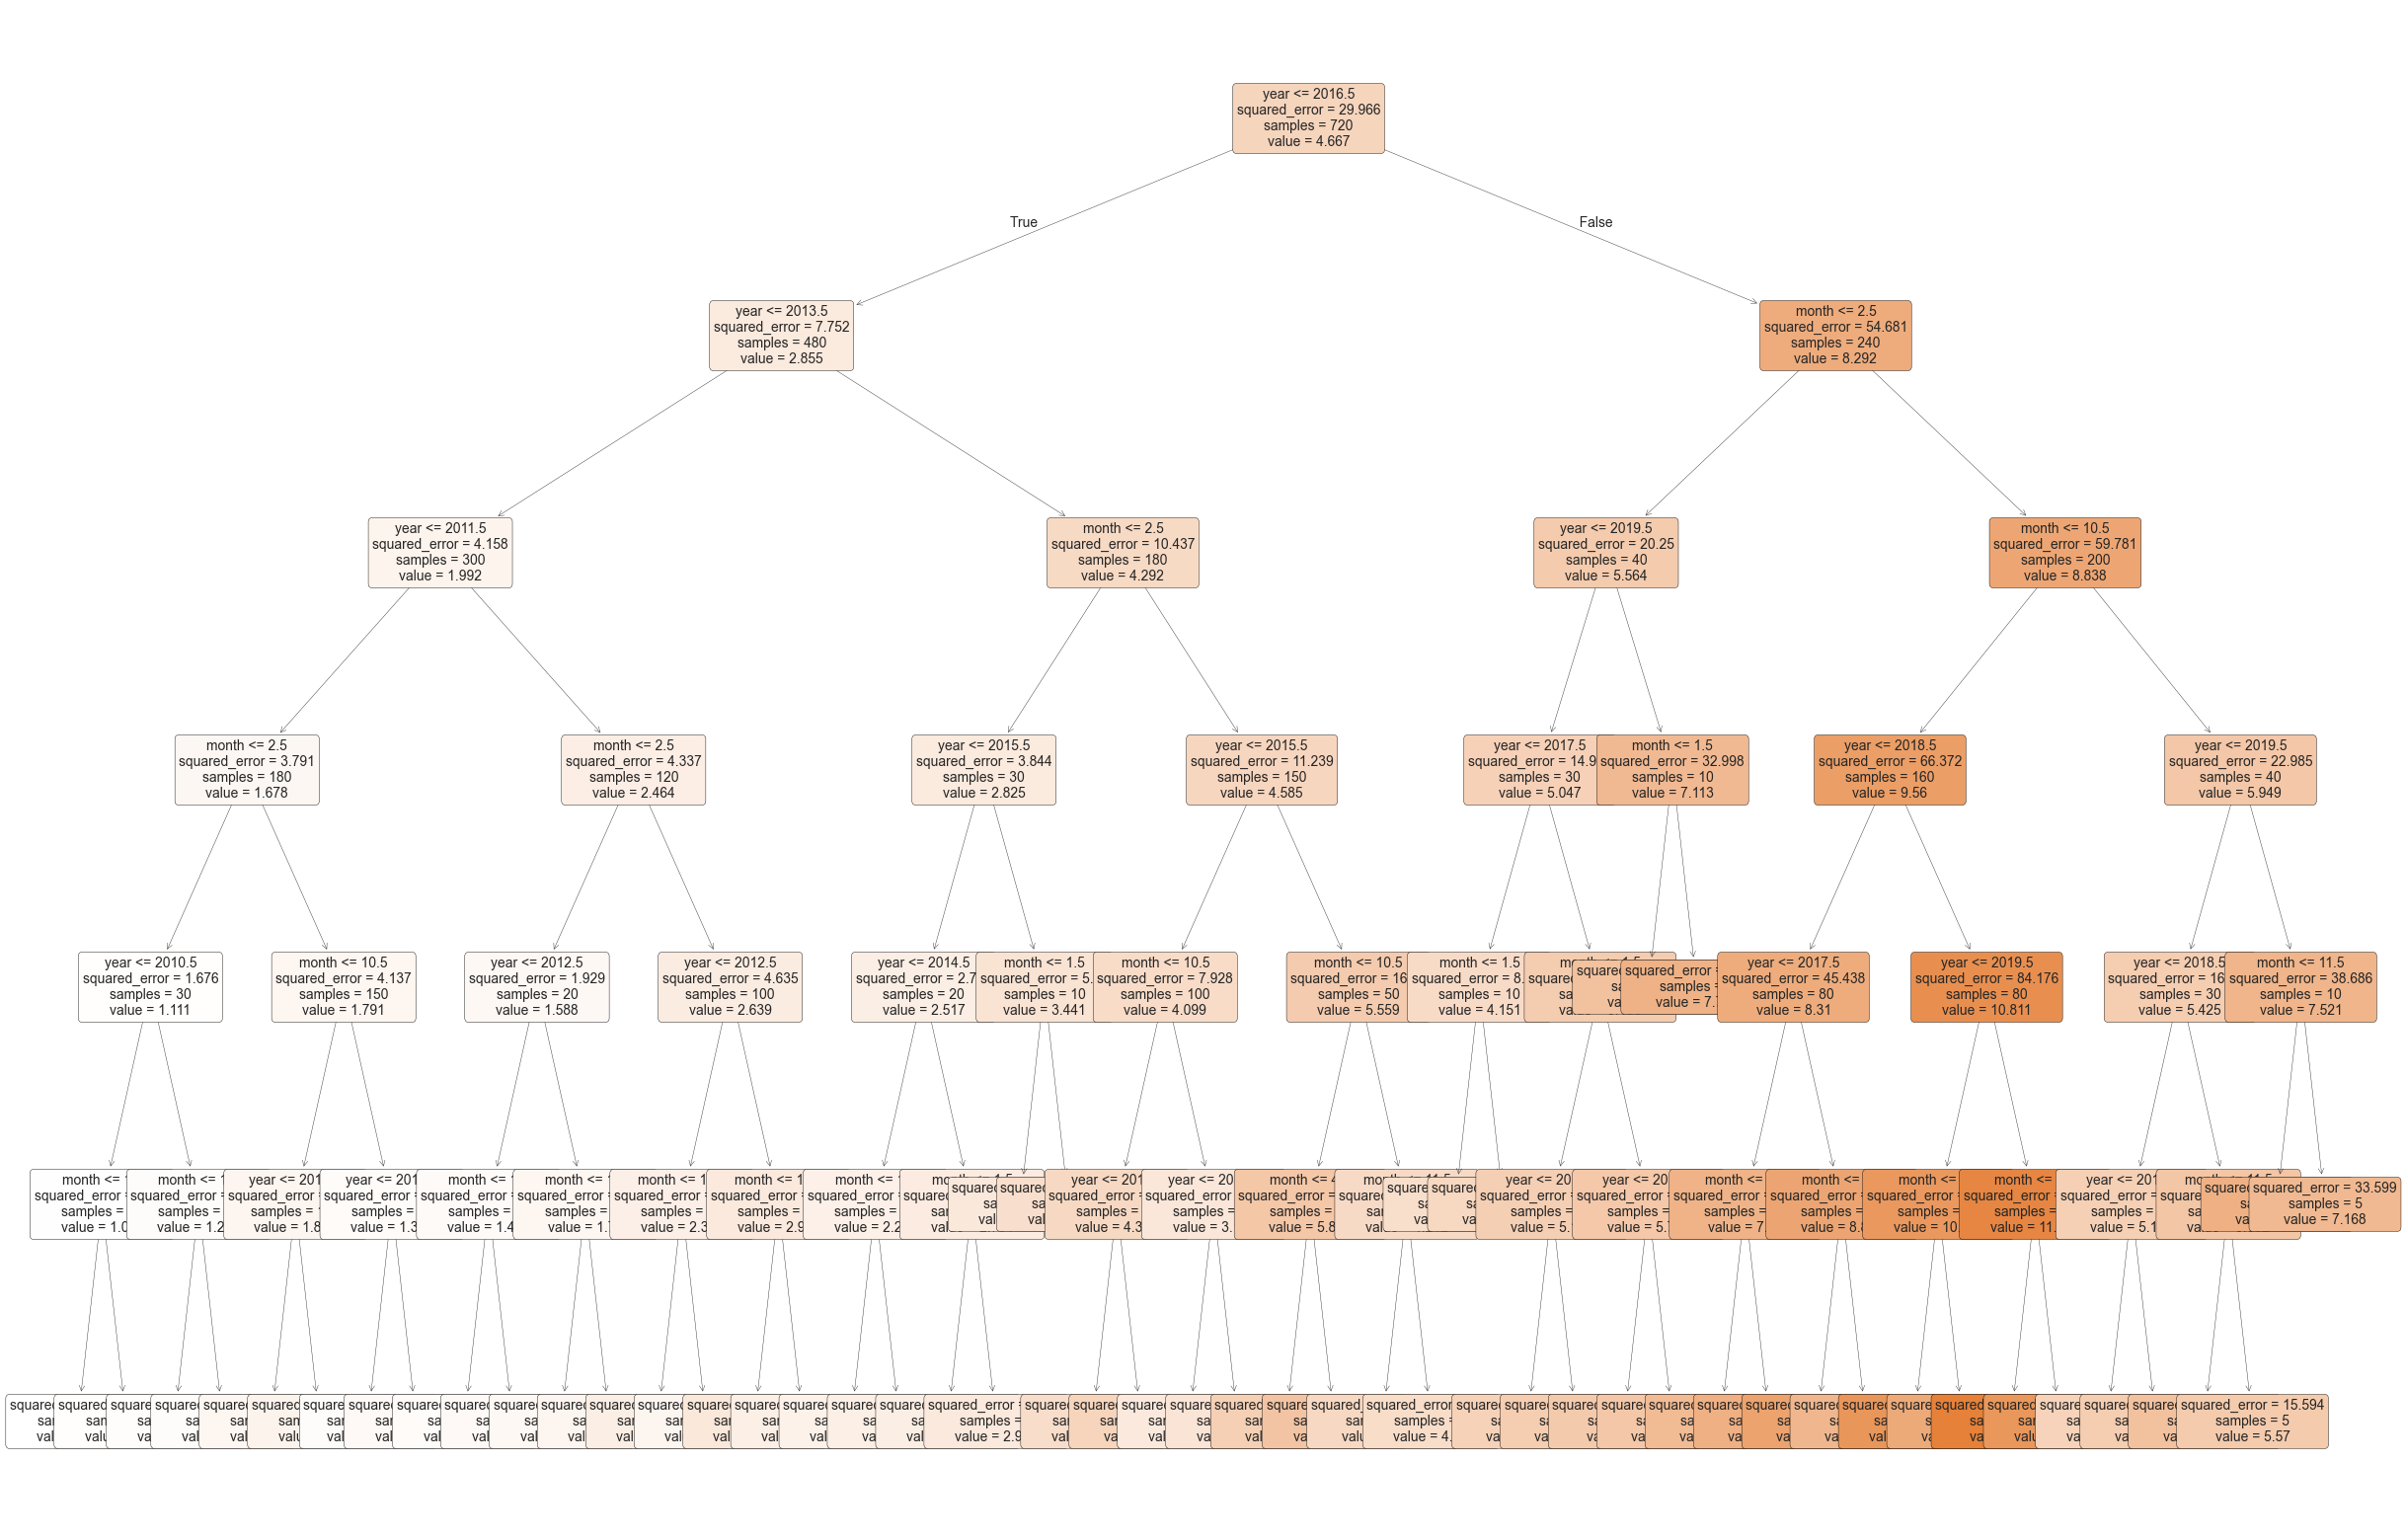

In [473]:
plt.figure(figsize=(30, 20))

# Plotear el árbol de decisión
plot_tree(
    dtr, 
    feature_names=X_train_reg.columns,  # Nombres de las características
    filled=True,                        # Colorea los nodos según la pureza
    rounded=True,                       # Bordes redondeados en los nodos
    fontsize=10                         # Tamaño de la fuente
)

# Mostrar el gráfico
plt.show()

## 2.4. Predicciones y Evaluación (Regresión)

* Realizar predicciones en el conjunto de prueba

In [474]:
y_pred_reg = dtr.predict(X_test_reg)

# Calcular métricas de evaluación
rmse_reg = mean_squared_error(y_test_reg, y_pred_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"\n--- Resultados de Evaluación para DecisionTreeRegressor ({target_reg}) ---")
print(f"RMSE (Error Cuadrático Medio Raíz): {rmse_reg:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_reg:.4f}")
print(f"R² (Coeficiente de Determinación): {r2_reg:.4f}")


--- Resultados de Evaluación para DecisionTreeRegressor (Solar Energy) ---
RMSE (Error Cuadrático Medio Raíz): 231.7049
MAE (Error Absoluto Medio): 10.3680
R² (Coeficiente de Determinación): -0.0570


* Visualización de Predicciones vs. Reales

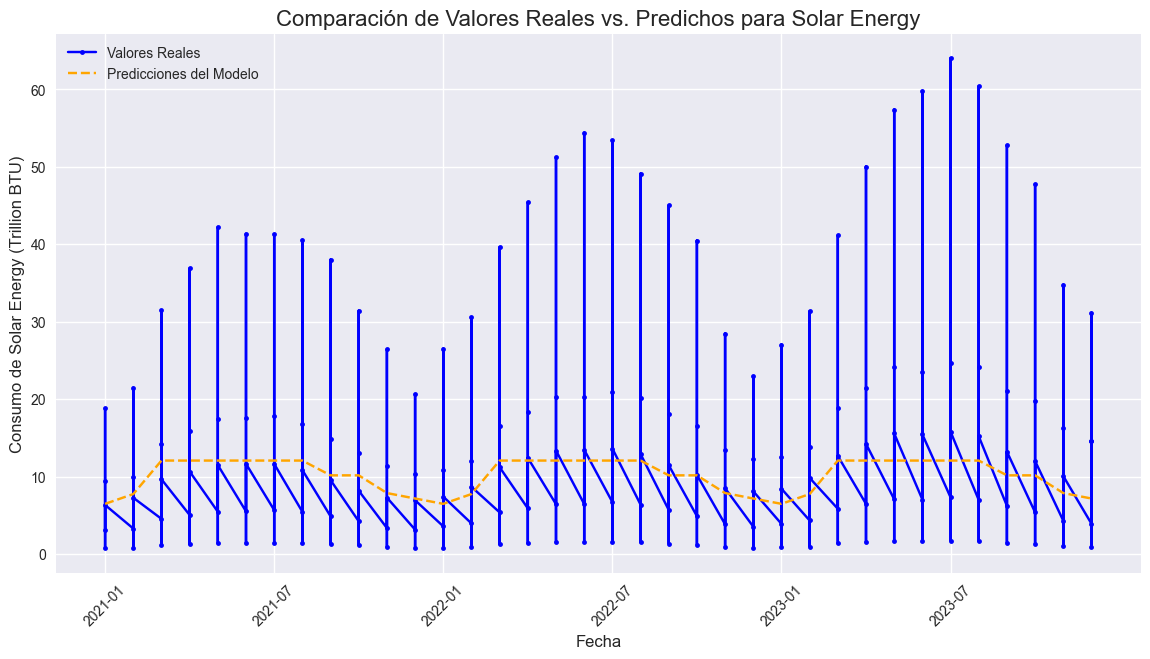

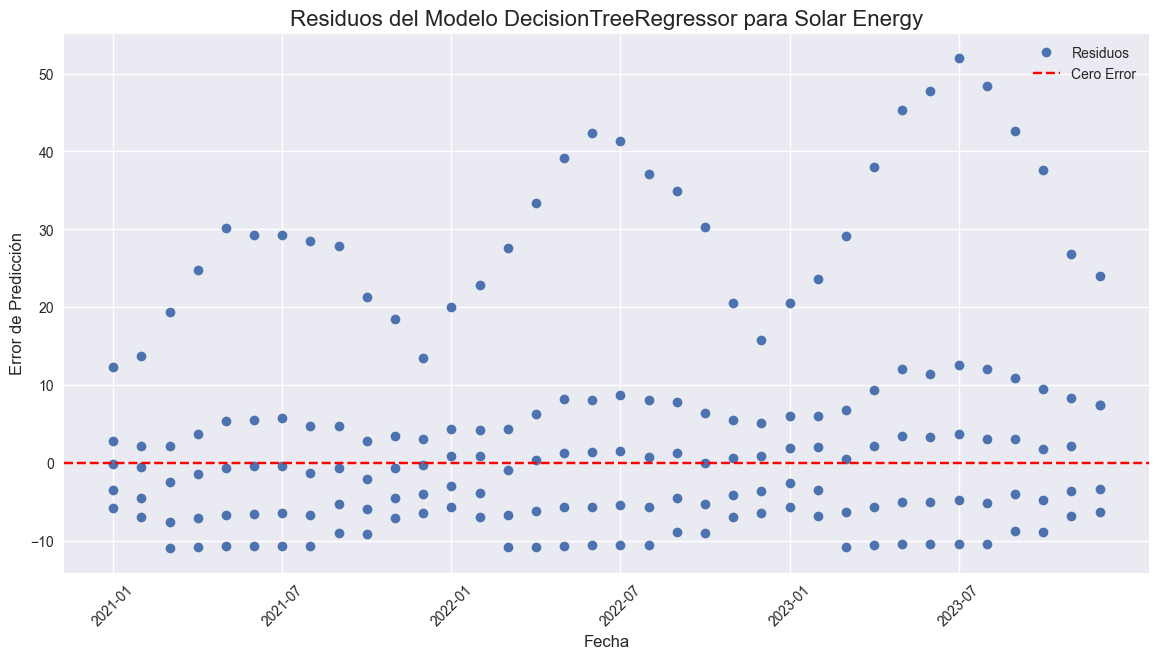

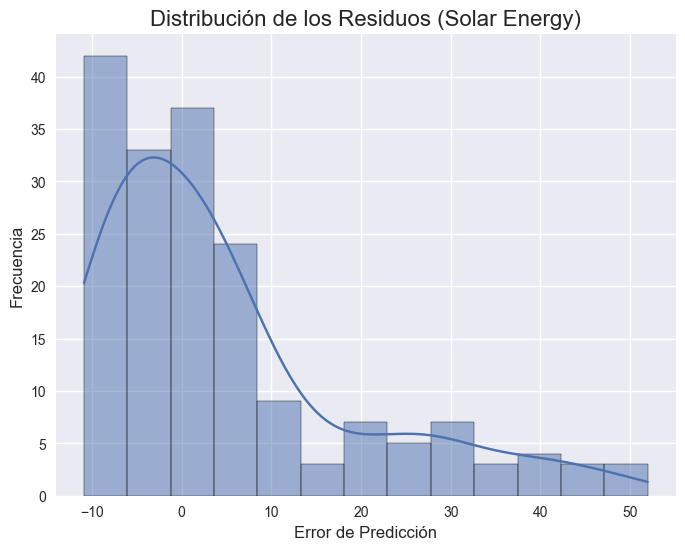

In [475]:
xticks = X_test_reg.index[::30]

plt.figure(figsize=(14, 7))
plt.plot(X_test_reg.index, y_test_reg, label='Valores Reales', marker='.', linestyle='-', color='blue')
plt.plot(X_test_reg.index, y_pred_reg, label='Predicciones del Modelo', marker='x', linestyle='--', color='orange')
plt.title(f'Comparación de Valores Reales vs. Predichos para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo de {target_reg} (Trillion BTU)', fontsize=12)
plt.xticks(ticks=xticks, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Residuos ---
# Los residuos son la diferencia entre los valores reales y los predichos
residuos_reg = y_test_reg - y_pred_reg
plt.figure(figsize=(14, 7))
plt.plot(X_test_reg.index, residuos_reg, label='Residuos', marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--', label='Cero Error')
plt.title(f'Residuos del Modelo DecisionTreeRegressor para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error de Predicción', fontsize=12)
plt.xticks(ticks=xticks, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(residuos_reg, kde=True)
plt.title(f'Distribución de los Residuos ({target_reg})', fontsize=16)
plt.xlabel('Error de Predicción', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

## Análisis de los resultados

El análisis del modelo DecisionTreeRegressor revela un rendimiento limitado en la predicción del consumo de energía solar. Si bien el modelo captura tendencias iniciales entre 2014 y 2020, subestima significativamente los picos de consumo a partir de 2020, con errores de hasta 60 trillones de BTU. Esto se refleja en un R² de -0.3701, un RMSE de 145.919 y un MAE de 7.219, indicando que, aunque muchos errores son pequeños, los errores en los valores altos afectan gravemente el ajuste. Se recomienda explorar modelos más robustos, como Random Forest o Gradient Boosting, para mejorar la precisión en la predicción de picos de consumo.

## 2.5. Optimizaci´no de Hiperparámetros

In [476]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de regresión.
param_grid_dtr = {
    'max_depth': [8, 10, 12, 16, None], # None significa sin límite
    'min_samples_split': [6, 8, 11],
    'min_samples_leaf': [6, 8, 10],
    'criterion': ['squared_error', 'absolute_error'] # Antes 'mse', 'mae'
}
# TimeSeriesSplit divide los datos en k folds consecutivos
tscv = TimeSeriesSplit(n_splits=5) # Usar menos splits si el dataset de entreno es pequeño

grid_search_dtr = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dtr,
    cv=tscv,
    scoring='neg_mean_squared_error', # GridSearchCV maximiza, por eso negativo
    verbose=1, # Muestra progreso
    n_jobs=-1 # Usa todos los procesadores
) 

grid_search_dtr.fit(X_train_reg, y_train_reg)

print(f"\nMejores Hiperparámetros para DecisionTreeRegressor: {grid_search_dtr.best_params_}")
print(f"Mejor puntuación (neg_MSE) en CV: {grid_search_dtr.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Mejores Hiperparámetros para DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 6}
Mejor puntuación (neg_MSE) en CV: -25.8179
